In [1]:
import numpy as np
import random
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
cancer = load_breast_cancer()
print(cancer.data.shape, cancer.target.shape)

(569, 30) (569,)


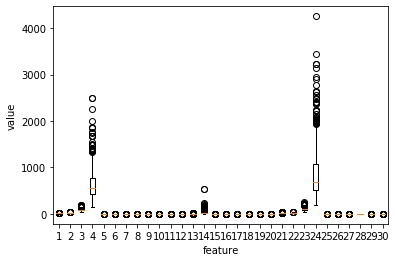

In [3]:
plt.boxplot(cancer.data)
plt.xlabel("feature")
plt.ylabel("value")
plt.show()

In [4]:
x = cancer.data
y = cancer.target 

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)  # 수정 금지 
x_train, x_eval, y_train, y_eval = train_test_split(x_train, y_train, stratify=y_train, test_size=0.125, random_state=999)

x_train_torch = torch.FloatTensor(x_train).cuda()
y_train_torch = torch.FloatTensor(y_train).cuda()
x_eval_torch = torch.FloatTensor(x_eval).cuda()
y_eval_torch = torch.FloatTensor(y_eval).cuda()
x_test_torch = torch.FloatTensor(x_test).cuda()
y_test_torch = torch.FloatTensor(y_test).cuda()

In [5]:
class LogisticNeuron2(nn.Module):
    def __init__(self, in_dim=30, n_hidden=16, learning_rate=1e-4):
        super(LogisticNeuron2, self).__init__()
        
        self.in_dim = in_dim
        self.n_hidden = n_hidden
        
        self._build()
        
        self.optim = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.bce_loss = nn.BCELoss()
        self.mse_loss = nn.MSELoss()
    
    def _build(self):
        dim_i = self.in_dim
        dim_d = self.n_hidden
        print('LN ver 2')
        self.model = nn.Sequential(
            nn.BatchNorm1d(dim_i),
            nn.Linear(dim_i, dim_d),
            nn.BatchNorm1d(dim_d),
            nn.LeakyReLU(),
            nn.Linear(dim_d, dim_d),
            nn.BatchNorm1d(dim_d),
            nn.LeakyReLU(),
            nn.Linear(dim_d,1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        z = self.model(x)
        return z
    
    def train(self, x, y, epochs=1000, batch_size=32):
        B = batch_size
        n = len(y)
        tmp_acc = -1
        for i in range(epochs):
            for j in range(0, n, B):
                if j+B > n:
                    m = n-j
                else:
                    m=B
                 
                xi = [v.unsqueeze(0) for v in x[j:(j+m)]]
                yi = y[j:(j+m)]
                
                xi = torch.cat(xi, dim=0)
                
                pred = self.forward(xi)
                loss = self.bce_loss(pred, yi)
                self.model.zero_grad()
                self.optim.zero_grad()
                
                loss.backward()
                self.optim.step()
            
            if (i + 1) % 100 == 0:
                acc = np.mean(self.predict(x_eval_torch) == y_eval)
                if tmp_acc == -1: 
                    tmp_acc = acc 
                if tmp_acc > acc:
                    break
                print("epoch {} : err = {:.4f}, eval acc = {:%}".format(i + 1, loss, acc))
    
    
    def predict(self, x, th=0.5):
        self.model.eval()
        pred= [self.forward(xi.unsqueeze(0)).data.cpu().numpy()[0] for xi in x]
        pred = np.array(pred).reshape(-1) > th
        self.model.train()
        return pred

In [6]:
random_seed = 123
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

ln2 = LogisticNeuron2(in_dim=30, n_hidden=32).cuda()
ln2.train(x_train_torch, y_train_torch, epochs=200, batch_size=32)

np.mean(ln2.predict(x_test_torch, th=0.5) == y_test) * 100

LN ver 2


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


epoch 100 : err = 0.0743, eval acc = 94.736842%
epoch 200 : err = 0.0175, eval acc = 96.491228%


99.12280701754386

In [7]:
random_seed = 123
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

ln22 = LogisticNeuron2(in_dim=30, n_hidden=32).cuda()
ln22.train(x_train_torch, y_train_torch, epochs=200, batch_size=32)

np.mean(ln22.predict(x_test_torch, th=0.5) == y_test) * 100

LN ver 2
epoch 100 : err = 0.0743, eval acc = 94.736842%
epoch 200 : err = 0.0175, eval acc = 96.491228%


99.12280701754386

In [8]:
random_seed = 123
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

ln222 = LogisticNeuron2(in_dim=30, n_hidden=32).cuda()
ln222.train(x_train_torch, y_train_torch, epochs=200, batch_size=32)

np.mean(ln222.predict(x_test_torch, th=0.5) == y_test) * 100

LN ver 2
epoch 100 : err = 0.0743, eval acc = 94.736842%
epoch 200 : err = 0.0175, eval acc = 96.491228%


99.12280701754386

In [15]:
class LogisticNeuronTest2(nn.Module):
    def __init__(self, in_dim, n_hidden, learning_rate=1e-4):
        
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(in_dim, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden//8),
            nn.Linear(n_hidden//8, 1),
            nn.Sigmoid()
        )
        
        self.optim = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.bce_loss = nn.BCELoss()
        
        self.x_train_min = None
        self.x_train_max = None
        self.y_train_min = None
        self.y_train_max = None
        
        
    def _calculate_loss(self, x, y):
        loss = self.bce_loss(x, y)
        return loss
    

    def norm(self, x, x_min=None, x_max=None):
        if x_min is None:
            x_min = torch.min(x, dim=0, keepdim=True)[0]
            x_max = torch.max(x, dim=0, keepdim=True)[0]

        x_ = (x - x_min) / (x_max - x_min)
        return x_, x_min, x_max
    
    
    def denorm(self, x, x_min=None, x_max=None):
        x_ = x * (x_max - x_min) + x_min
        return x_
    
    
    def forward(self, x):
        z = self.model(x)
        return z
    
    
    def train(self, x, y, x_eval, y_eval, epochs=100, batch_size=32):
        B = batch_size
        n = len(y)
        temp_acc = -1
        
        x_, self.x_train_min, self.x_train_max = self.norm(x)
        y_, self.y_trian_min, self.y_train_max = self.norm(y)
        
        for i in range(epochs):
            for j in range(0, n, B):
                if (j+B) > n:
                    m=n-j
                else:
                    m=B

                xi = [v.unsqueeze(0) for v in x_[j:j+m]]
                yi = y_[j:j+m]
                
                xi = torch.cat(xi, dim=0)

                pred = self.forward(xi)
                loss = self._calculate_loss(pred, yi)
                
                self.model.zero_grad()
                self.optim.zero_grad()
                
                loss.backward()
                self.optim.step()
                
            if (i+1) % 10 == 0:
                _pred = self.predict(x_eval)
                acc = np.mean(_pred == y_eval)
                if temp_acc == -1:
                    temp_acc = acc
                if temp_acc > acc:
                    break
                print("epochs : {} | loss : {:.4f} | acc : {:%} ".format(i+1, loss, acc))
    
    
    def predict(self, x, th=0.5):
        x_, _, _ = self.norm(x, self.x_train_min, self.x_train_max)
        _pred = self.forward(x_).data.numpy().reshape(-1)
        _pred = _pred > th
        return _pred
    

In [17]:
random_seed=123
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

lnt2 = LogisticNeuronTest2(in_dim=30, n_hidden=140).cuda()
lnt2.train(x_train_torch, y_train_torch, x_eval_torch, y_eval, epochs=600, batch_size=32)

np.mean(lnt2.predict(x_test_torch) == y_test) * 100

epochs : 10 | loss : 0.6590 | acc : 63.157895% 
epochs : 20 | loss : 0.5369 | acc : 89.473684% 
epochs : 30 | loss : 0.3615 | acc : 89.473684% 
epochs : 40 | loss : 0.2329 | acc : 89.473684% 
epochs : 50 | loss : 0.1637 | acc : 89.473684% 
epochs : 60 | loss : 0.1258 | acc : 91.228070% 
epochs : 70 | loss : 0.1029 | acc : 92.982456% 
epochs : 80 | loss : 0.0874 | acc : 94.736842% 
epochs : 90 | loss : 0.0761 | acc : 94.736842% 
epochs : 100 | loss : 0.0674 | acc : 96.491228% 
epochs : 110 | loss : 0.0604 | acc : 96.491228% 
epochs : 120 | loss : 0.0548 | acc : 96.491228% 
epochs : 130 | loss : 0.0501 | acc : 96.491228% 
epochs : 140 | loss : 0.0463 | acc : 96.491228% 
epochs : 150 | loss : 0.0430 | acc : 96.491228% 
epochs : 160 | loss : 0.0402 | acc : 96.491228% 
epochs : 170 | loss : 0.0377 | acc : 96.491228% 
epochs : 180 | loss : 0.0356 | acc : 96.491228% 
epochs : 190 | loss : 0.0336 | acc : 96.491228% 
epochs : 200 | loss : 0.0320 | acc : 96.491228% 
epochs : 210 | loss : 0.0304 

99.12280701754386